# Stochastic Dual Coordinate Ascent

#### Guillaume DESFORGES, Michaël KARPE, Matthieu ROUX

###### Libraries importation

In [611]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize_scalar, minimize
#import bigfloat
#from lightning.classification import SDCAClassifier
#from lightning.regression import SDCARegressor

from copy import deepcopy
from malaptools import *

###### Global variables

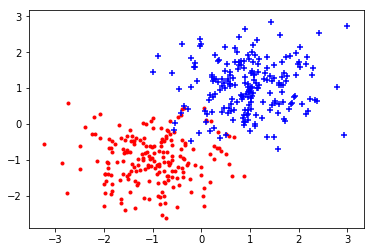

In [612]:
n = 500
d = 1
T = 500#500
lamb = 1

#X = np.random.rand(n,d)
#Y = np.random.rand(n)

#X = np.random.normal(0, 1, (n,d))
#Y = np.random.normal(0, 1, n)

def gen_linear(a,b,eps,nbex):
    X=np.array([np.random.uniform(-5,5) for i in range(nbex)])
    Y=np.array([a*x+b+np.random.normal(0,np.sqrt(eps)) for x in X])
    return X.reshape(-1,1),Y.reshape(-1,1)

#X,Y = gen_linear(1,0,1,1000)
#plt.scatter(X,Y)

ratio = 0.8
n_train = 400
n_test = 100
X_train, y_train = gen_arti(data_type = 0, sigma = 0.5, nbex = n_train, epsilon = 0.1)
X_test, y_test = gen_arti(data_type = 0, sigma = 0.5, nbex = n_test, epsilon = 0.1)
plot_data(X_train, y_train)
plt.show()

###### Loss function

In [613]:
def phi(y,a,loss):
    if loss == "square_loss":
        return np.array([(a-y[i])**2 for i in range(len(y))]).reshape(-1,1)
    elif loss == "hinge_loss":
        return np.array([max(0,1-y[i]*a) for i in range(len(y))]).reshape(-1,1)
    elif loss == "logistic_loss":
        return np.array([np.log(1+np.exp(-y[i]*a)) for i in range(len(y))]).reshape(-1,1)
    elif loss == "absolute_loss":
        return np.array([np.abs(a-y[i]) for i in range(len(y))]).reshape(-1,1)
    elif loss == "smoothed_hinge_loss":
        return np.array([max(0,1-a) for i in range(len(y))]).reshape(-1,1)

###### Convex conjugate

In [614]:
def phi_star(y,u,loss):
    phi_0 = []
    for i in range(len(y)):
        def phi_i(z):
            return phi(y,z,loss)[i]
        def f(z):
            return -(z*u-phi_i(z))
        phi_0.append(-minimize_scalar(f).fun)
    return np.array(phi_0).reshape(-1,1)

###### Illustration of 'minimize_scalar' function: How does it work?

In [1]:
def f(x):
    return (x - 2) * x * (x + 2)**2

X = np.linspace(-2,2,100)
plt.plot(X,[f(x) for x in X])
plt.show()

res = minimize_scalar(f)

print(res)
print(res.x)
print(res.fun)

NameError: name 'np' is not defined

###### Computation of w (called f_w)

In [615]:
def f_w(alpha,x):
    n=len(alpha)
    #return np.vdot(alpha,x)/(lamb*n)
    #print("alpha x", [alpha[i]*x[i] for i in range(n)])
    return np.array(sum([[alpha[i]*x[i] for i in range(n)][j] for j in range(d)]))/(lamb*n)

###### Closed forms for $\Delta \alpha_i$

In [616]:
gamma = 1

def incr_solution(y,a,loss,x,w):
    if loss == "square_loss":
        #print("x", x)
        #print("w", w)
        #print(np.dot(x.T,w))
        return (y-np.dot(x.T,w)-a/2)/(0.5+np.linalg.norm(x)**2/(lamb*n))
    elif loss == "hinge_loss":
        return y*max(0,min(1,(1-np.dot(x.T,w)*y)/(np.linalg.norm(x)**2/(lamb*n))+a*y))-a
    elif loss == "absolute_loss":
        return max(-1,min(1,(y-np.dot(x.T,w)*y)/(np.linalg.norm(x)**2/(lamb*n))+a))-a
    elif loss == "logistic_loss":
        return (y/(1+np.exp(np.dot(x.T,w)*y))-a)/max(1,0.25+np.linalg.norm(x)**2/(lamb*n))
    elif loss == "smoothed_hinge_loss":
        return y*max(0,min(1,(1-np.dot(x.T,w)*y-gamma*a*y)/(np.linalg.norm(x)**2/(lamb*n)+gamma)+a*y))-a

###### Computation of SDCA

In [617]:
def SDCA(y,loss,x,T_0,output_type,verbose = False):
    n = len(x)
    
    alpha = np.random.rand(n)
    alpha_t = [0]*(T+1)
    alpha_t[0] = alpha
    alpha_coefs = [[alpha[i]] for i in range(len(alpha))]
    
    w_t = [0]*(T+1)
    w_t[0] = f_w(alpha,x)

    for t in range(1,T+1):
        i = np.random.randint(n)
        
        def f(z):
            return phi_star(y, -(alpha_t[t-1][i]+z), loss)[i]+lamb*n/2*np.linalg.norm(w_t[t-1]+z*x[i]/(lamb*n))**2
        delta_i = incr_solution(y[i],alpha_t[t-1][i],loss,x[i],w_t[t-1])#minimize(f, 0, method='nelder-mead').x #minimize_scalar(f).x
        
        w_t[t] = w_t[t-1] + delta_i*x[i]/(lamb*n)
        alpha_t[t] = deepcopy(alpha_t[t-1]) 
        alpha_t[t][i] += delta_i
        
        if verbose:
            for i in range(len(alpha)):
                alpha_coefs[i].append(alpha_t[t][i])
            sum_alpha_coefs = [sum([alpha_coefs[i][j] for i in range(len(alpha_coefs))]) for j in range(len(alpha_coefs[0]))]
    
    if verbose:
        for i in range(len(alpha[:20])):
            plt.subplot(1,2,1)
            plt.plot(range(1,len(alpha_coefs[i])+1),alpha_coefs[i])
            plt.title("Evolution of alpha coefs at each iteration")
            plt.xlabel("t")
            plt.ylabel("alpha")
        plt.subplot(1,2,2)
        plt.plot(range(1,len(sum_alpha_coefs)),[abs(sum_alpha_coefs[i+1]-sum_alpha_coefs[i]) for i in range(len(sum_alpha_coefs)-1)],label="Evolution of alpha")
        plt.title("Evolution of alpha coefs variation at each iteration")
        plt.xlabel("t")
        plt.ylabel("Variation")
        plt.legend()
        plt.subplots_adjust(bottom=0.2, right=2, top=1, wspace=0.3, hspace=0.3)
        plt.show()
    
    if output_type == "averaging":
        #return sum([w_t[i] for i in range(T_0,T)])/(T-T_0)
        return w_t
    elif output_type == "random":
        #return w_t[np.random.randint(T-T_0)+T_0+1]
        return w_t

###### Execution of SDCA (only square_loss works for now)

In [618]:
losses = ["square_loss", "hinge_loss", "absolute_loss", "logistic_loss", "smoothed_hinge_loss"]
outputs = ["averaging", "random"]

In [619]:
def predict_y(w,X):
    #ones=np.array([1 for i in range(len(X))]).reshape(-1,1)
    #return np.dot(np.concatenate((ones,X), axis=1),w)
    return np.dot(X,w)
    
def mse(yhat,y):
    n=len(y)
    return sum([(yhat[i]-y[i])**2 for i in range(n)])/n

/usr/local/lib/python3.5/dist-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


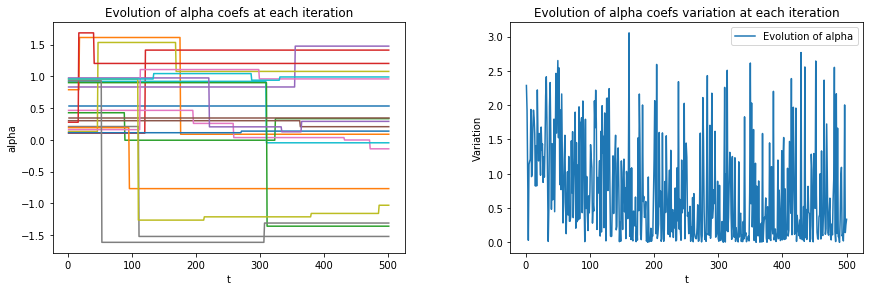

0.219002113001


In [620]:
w_hat =  SDCA(y_train,losses[0],X_train,T//2,outputs[0],True)[-1]
y_hat = predict_y(w_hat,X_train)
print(mse(y_hat,y_train))

y_train_predict = predict_y(w_hat,X_train)
y_test_predict = predict_y(w_hat,X_test)

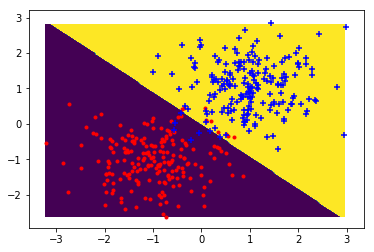

In [621]:
def predict(X):
    Y_pred = np.dot(X, w_hat)
    Y_pred[Y_pred > 0] = 1
    Y_pred[Y_pred <= 0] = -1
    return Y_pred

plot_frontiere(X_train, predict, step=200)
plot_data(X_train,y_train)
plt.show()

In [627]:
def plot_mse_data(y,loss,x,output_type,label,verbose = False):
    MSE=[]
    for i in range(1,T//5):
        MSEbis=[]
        #Boucle permettant "d'annuler" l'effet de l'aléatoire
        for j in range(5):
            w_hat =  SDCA(y,loss,x,T//2,output_type,verbose)[5*i]
            y_hat = predict_y(w_hat,X)
            MSEbis.append(mse(y_hat,Y))
        MSE.append(np.mean(MSEbis))
    plt.plot(range(1,T//5),MSE,label=label)
    #print(MSE)
    plt.xlabel('Nombre de données')
    plt.ylabel('Erreur moyenne des moindres carrés')
    plt.legend()

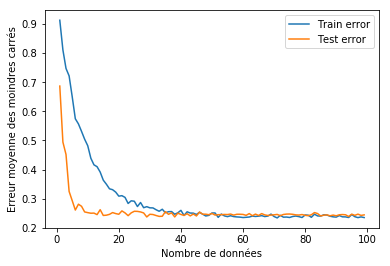

In [628]:
plot_mse_data(y_train,losses[0],X_train,outputs[0],label = "Train error",verbose = False)
plot_mse_data(y_test,losses[0],X_test,outputs[0],label = "Test error",verbose = False)
plt.show()